In [1]:
#!pip install janome

import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch import nn, Tensor
import torch.nn.functional as F
#from torchtext.vocab import vocab
#import torchtext.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import math
import janome
from janome.tokenizer import Tokenizer
import spacy
from collections import Counter
from torch.utils.data.sampler import SubsetRandomSampler
import time
#from torchtext.vocab import build_vocab_from_iterator
import levenshtein
import json
import pickle
from timm.scheduler import CosineLRScheduler
import nltk
from nltk import bleu_score

In [2]:
token_list_path = "20240512_ntt_idx_to_wakati_len.json"
with open( token_list_path, mode="r" , encoding="utf-8" ) as f:
    token_list = json.load( f )

token_list_en_path = "20240512_ntt_idx_to_word_len.json"
with open( token_list_en_path, mode="r" , encoding="utf-8" ) as f:
    token_list_en = json.load( f )

idx_list_path = "20240512_ntt_wakati_to_idx_len.json"
with open( idx_list_path, mode="r" , encoding="utf-8" ) as f:
    idx_list = json.load( f )

idx_list_en_path = "20240512_ntt_word_to_idx_len.json"
with open( idx_list_en_path, mode="r" , encoding="utf-8" ) as f:
    idx_list_en = json.load( f )
    
enc_vocab_size, dec_vocab_size = len(token_list) - 1, len(token_list_en) - 1
print(enc_vocab_size, dec_vocab_size)

184858 181274


In [3]:
a = torch.tensor( [ 0,1,2,3,4,5,6 ])

b = [ token_list[str(i.item())] for i in a ]

print( b )


d = idx_list['<pad>']

print( d )

['<blank>', '<bos>', '<eos>', '<unk>', '<mask>', '<pad>', '<len>']
5


In [4]:
# -*- coding: utf-8 -*-

#
# Pytorchで用いるDatasetの定義
#

# PytorchのDatasetモジュールをインポート
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# 数値演算用モジュール(numpy)をインポート
import numpy as np

# sysモジュールをインポート
import sys


class SequenceDataset(Dataset):
    ''' ミニバッチデータを作成するクラス
        torch.utils.data.Datasetクラスを継承し，
        以下の関数を定義する
        __len__: 総サンプル数を出力する関数
        __getitem__: 1サンプルのデータを出力する関数
    feat_scp:  特徴量リストファイル
    label_scp: ラベルファイル
    feat_mean: 特徴量の平均値ベクトル
    feat_std:  特徴量の次元毎の標準偏差を並べたベクトル 
    pad_index: バッチ化の際にフレーム数を合わせる
               ためにpaddingする整数値
    splice:    前後(splice)フレームを特徴量を結合する
               splice=1とすると，前後1フレーム分結合
               するので次元数は3倍になる．
               splice=0の場合は何もしない
    '''
    def __init__(self, 
                 filename,
                 pad_index_j=idx_list['<pad>'],
                 pad_index_e=idx_list_en['<pad>'],
                 ):

        # 特徴量リスト，ラベルを1行ずつ
        # 読み込みながら情報を取得する
        self.pad_index_j = pad_index_j
        self.pad_index_e = pad_index_e
        #self.ens = []
        self.en_list = []
        self.en_lens = []
        #self.jps = []
        self.jp_list = []
        self.jp_lens = []
        self.num_data = 0
        with open(filename, mode='r', encoding="utf-8") as file_f:
            for line in file_f:
                line = line.replace( "\n", "" )
                # 各行をスペースで区切り，
                # リスト型の変数にする
                #print( "line:", line)
                en = line.split("\t")[1]
                #self.ens.append( en )
                #self.ens = self.ens
                en1 = en.split( ' ' )
                self.en_list.append( en1 )
                self.en_lens.append( len( en1 ) )

                jp = line.split("\t")[0]
                #self.jps.append( jp )
                #self.jps = self.jps
                jp1 = jp.split( ' ' )
                self.jp_list.append( jp1 )
                self.jp_lens.append( len( jp1 ) )
                self.num_data += 1

        self.en_lens = np.int64( np.array( self.en_lens ) )
        self.jp_lens = np.int64( np.array( self.jp_lens ) )


        # フレーム数の最大値を得る
        self.max_en_len = np.max(self.en_lens)
        # ラベル長の最大値を得る
        self.max_jp_len = np.max(self.jp_lens)

        # ラベルデータの長さを最大フレーム長に
        # 合わせるため，pad_indexの値で埋める
        for n in range(self.num_data):
            print( "n:", n )
            # 埋めるフレームの数
            # = 最大フレーム数 - 自分のフレーム数
            pad_len = self.max_en_len \
                    - self.en_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            tmp = self.en_list[n]
            self.en_list[n] = np.pad( tmp, (0, pad_len), mode='constant', constant_values=(self.pad_index_e, self.pad_index_e ))
            #print( self.en_list[n][0].dtype )
            #tmp = torch.tensor( self.en_list[n] )
            #tmp = F.pad( tmp, (0, pad_len), 'constant', self.pad_index_e )
            #self.en_list[n] = tmp.to('cpu').detach().numpy().copy()
            #print( self.en_list[n] )
            #tmp = torch.tensor( self.en_list[n] )
            #if torch.any( tmp == 5785 ):
            #    print( "tmp == 5785" )
            pad_len = self.max_jp_len \
                    - self.jp_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            self.jp_list[n] = np.pad(self.jp_list[n],[0, pad_len],mode='constant', constant_values=self.pad_index_j)

        self.en_list = np.int64( np.array( self.en_list ) )
        self.jp_list = np.int64( np.array( self.jp_list ) )
        #print( self.jp_list )

        #max = np.max( self.jp_list, axis =1 )
        #maxmax = np.max( max )
        #print( "maxmax:{}".format(maxmax) )


    def __len__(self):
        ''' 学習データの総サンプル数を返す関数
        本実装では発話単位でバッチを作成するため，
        総サンプル数=発話数である．
        '''
        return self.num_data


    def __getitem__(self, idx):
        ''' サンプルデータを返す関数
        本実装では発話単位でバッチを作成するため，
        idx=発話番号である．
        '''
        # 特徴量系列のフレーム数
        jp_len = self.jp_lens[idx]
        # ラベルの長さ
        en_len = self.en_lens[idx]

        # ラベル
        jp = self.jp_list[idx]
        #print( jp )
        #jp = np.fromfile(self.jp_list[idx],dtype=np.int64)

        # 発話ID
        en = self.en_list[idx]
        #ens = np.fromfile(self.en_list[idx],dtype=np.float32)

        #batch = {}
        #batch['jp'] = jp
        #batch['en'] = en
        #batch['jp_len'] = jp_len
        #batch['en_len'] = en_len


        # 特徴量，ラベル，フレーム数，
        # ラベル長，発話IDを返す
        #return (jps, jp_lens, ens,  en_lens)
        return (jp, en, jp_len, en_len )

In [5]:
BATCH_SIZE = 20
batch_size = BATCH_SIZE

#train_dataset = SequenceDataset( "20240512_ntt_ids_train_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )
train_dataset = SequenceDataset( "20240512_ntt_ids_dev_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
val_dataset = SequenceDataset( "20240512_ntt_ids_dev_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
    
# 訓練データのDataLoaderを呼び出す
# 訓練データはシャッフルして用いる
#  (num_workerは大きい程処理が速くなりますが，
#   PCに負担が出ます．PCのスペックに応じて
#   設定してください)

num_workers = 4 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers)
# 開発データのDataLoaderを呼び出す
# 開発データはデータはシャッフルしない
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

print( len( train_loader ))
print( len( val_loader ))


text, target, text_len, target_len = next(iter(train_loader))
print(text[0], target[0], text_len[0],target_len[0], sep="\n")

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 2218
n: 2219
n: 2220
n: 2221
n: 2222
n: 2223
n: 2224
n: 2225
n: 2226
n: 2227
n: 2228
n: 2229
n: 2230
n: 2231
n: 2232
n: 2233
n: 2234
n: 2235
n: 2236
n: 2237
n: 2238
n: 2239
n: 2240
n: 2241
n: 2242
n: 2243
n: 2244
n: 2245
n: 2246
n: 2247
n: 2248
n: 2249
n: 2250
n: 2251
n: 2252
n: 2253
n: 2254
n: 2255
n: 2256
n: 2257
n: 2258
n: 2259
n: 2260
n: 2261
n: 2262
n: 2263
n: 2264
n: 2265
n: 2266
n: 2267
n: 2268
n: 2269
n: 2270
n: 2271
n: 2272
n: 2273
n: 2274
n: 2275
n: 2276
n: 2277
n: 2278
n: 2279
n: 2280
n: 2281
n: 2282
n: 2283
n: 2284
n: 2285
n: 2286
n: 2287
n: 2288
n: 2289
n: 2290
n: 2291
n: 2292
n: 2293
n: 2294
n: 2295
n: 2296
n: 2297
n: 2298
n: 2299
n: 2300
n: 2301
n: 2302
n: 2303
n: 2304
n: 2305
n: 2306
n: 2307
n: 2308
n: 2309
n: 2310
n: 2311
n: 2312
n: 2313
n: 2314
n: 2315
n: 2316
n: 2317
n: 2318
n: 2319
n: 2320
n: 2321
n: 2322
n: 2323
n: 2324
n: 2325
n: 2326
n: 2327
n: 2328
n: 2329
n: 2330
n: 2331
n: 2332
n: 2333
n: 2334
n: 2335
n: 2336
n: 2337
n: 2338
n: 2339
n: 2340
n: 2341
n: 2342


n: 3278
n: 3279
n: 3280
n: 3281
n: 3282
n: 3283
n: 3284
n: 3285
n: 3286
n: 3287
n: 3288
n: 3289
n: 3290
n: 3291
n: 3292
n: 3293
n: 3294
n: 3295
n: 3296
n: 3297
n: 3298
n: 3299
n: 3300
n: 3301
n: 3302
n: 3303
n: 3304
n: 3305
n: 3306
n: 3307
n: 3308
n: 3309
n: 3310
n: 3311
n: 3312
n: 3313
n: 3314
n: 3315
n: 3316
n: 3317
n: 3318
n: 3319
n: 3320
n: 3321
n: 3322
n: 3323
n: 3324
n: 3325
n: 3326
n: 3327
n: 3328
n: 3329
n: 3330
n: 3331
n: 3332
n: 3333
n: 3334
n: 3335
n: 3336
n: 3337
n: 3338
n: 3339
n: 3340
n: 3341
n: 3342
n: 3343
n: 3344
n: 3345
n: 3346
n: 3347
n: 3348
n: 3349
n: 3350
n: 3351
n: 3352
n: 3353
n: 3354
n: 3355
n: 3356
n: 3357
n: 3358
n: 3359
n: 3360
n: 3361
n: 3362
n: 3363
n: 3364
n: 3365
n: 3366
n: 3367
n: 3368
n: 3369
n: 3370
n: 3371
n: 3372
n: 3373
n: 3374
n: 3375
n: 3376
n: 3377
n: 3378
n: 3379
n: 3380
n: 3381
n: 3382
n: 3383
n: 3384
n: 3385
n: 3386
n: 3387
n: 3388
n: 3389
n: 3390
n: 3391
n: 3392
n: 3393
n: 3394
n: 3395
n: 3396
n: 3397
n: 3398
n: 3399
n: 3400
n: 3401
n: 3402


n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3447
n: 3448
n: 3449
n: 3450
n: 3451
n: 3452
n: 3453
n: 3454
n: 3455
n: 3456
n: 3457
n: 3458
n: 3459
n: 3460
n: 3461
n: 3462
n: 3463
n: 3464
n: 3465
n: 3466
n: 3467
n: 3468
n: 3469
n: 3470
n: 3471
n: 3472
n: 3473
n: 3474
n: 3475
n: 3476
n: 3477
n: 3478
n: 3479
n: 3480
n: 3481
n: 3482
n: 3483
n: 3484
n: 3485
n: 3486
n: 3487
n: 3488
n: 3489
n: 3490
n: 3491
n: 3492
n: 3493
n: 3494
n: 3495
n: 3496
n: 3497
n: 3498
n: 3499
n: 3500
n: 3501
n: 3502
n: 3503
n: 3504
n: 3505
n: 3506
n: 3507
n: 3508
n: 3509
n: 3510
n: 3511
n: 3512
n: 3513
n: 3514
n: 3515
n: 3516
n: 3517
n: 3518
n: 3519
n: 3520
n: 3521
n: 3522
n: 3523
n: 3524
n: 3525
n: 3526
n: 3527
n: 3528
n: 3529
n: 3530
n: 3531
n: 3532
n: 3533
n: 3534
n: 3535
n: 3536
n: 3537
n: 3538
n: 3539
n: 3540
n: 3541
n: 3542
n: 3543
n: 3544
n: 3545
n: 3546
n: 3547
n: 3548
n: 3549
n: 3550
n: 3551
n: 3552
n: 3553
n: 3554
n: 3555
n: 3556
n: 3557
n: 3558
n: 3559
n: 3560
n: 3561
n: 3562
n: 3563
n: 3564
n: 3565
n: 3566
n: 3567
n: 3568
n: 3569
n: 3570
n: 3571


250
250
tensor([    6,     1,  3391,    10,    30,    40, 11979,    72,    27,  4406,
           12,  4273,    32,  1060,    32,    56,    49,    22,     2,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
            5,     5,     5,     5])
tensor([    1,    19, 11148,   294,  2968,    33,   430,  2807, 29060,  3734,
           16,     

In [5]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=1024):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

In [6]:
class TransformerEncoder(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, text_vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int,  num_layers: int, pad_index:int ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            text_vocab_size, dim_embedding, padding_idx=pad_index)        
        
        # 位置エンコーディング
        #self.positional_encoding = PositionalEncoding(dim_embedding)   
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.embed_lengths = nn.Embedding(1024, dim_embedding)
        nn.init.normal_(self.embed_lengths.weight, mean=0, std=0.02)
        
        # Transformerエンコーダ層
        #self.layers = nn.ModuleList([TransformerEncoderLayer(
        #    dim_embedding, num_heads, dim_feedforward
        #) for _ in range(num_layers)])
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])

        # ロジットを生成する前のレイヤー正規化と全結合
        #self.norm = nn.LayerNorm(dim_embedding)
        #self.linear = nn.Linear( dim_embedding, 1 )
        
        self.pad_index = pad_index
        #self._reset_parameters2()
        
    #def _reset_parameters2(self):
    #    config = ConfigTrain()        
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            #nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    #def forward(self, x: torch.Tensor, mask: torch.Tensor=None ):
    def forward(self, x: torch.Tensor, mask_src: torch.Tensor=None, padding_mask_src: torch.Tensor=None ):

        #print("0 x size:", x.size())
        x = self.embed( x )
        #print("1 x size:", x.size())
        
        position = self.pos_emb( x )
        x = x + position
        #x = self.pos_enc( x )

        #print("2 x size:", x.size())
        
        # Transformerエンコーダ層を適用
        #for layer in self.layers:
        for layer in self.encoder_layers:
            #x = layer(x, padding_mask = mask)
            x = layer( x, src_key_padding_mask = padding_mask_src )

        #print("3 x size:", x.size())
            
        #x = self.norm(x)
        #print( "size of x[:,0,:]:",x[:,0,:].size())
        #print( "size of self.pos_emb.pos_emb.weight.tranpose(0,1):",self.pos_emb.pos_emb.weight.transpose(0,1).size())
        predicted_lengths_logits = torch.matmul( x[:,0,:], self.embed_lengths.weight.transpose(0,1)).float()
        predicted_lengths_logits [:,0] += float('-inf')
        predicted_lengths = F.log_softmax( predicted_lengths_logits, dim = -1 )
        #length = torch.squeeze( self.linear( length ), dim = 1 )
        #enc_out = torch.zeros_like( x )
        enc_out = x[:,1:,:]
        
        return enc_out, predicted_lengths

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

In [7]:
class TransformerDecoder(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    pad_index      : PADのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, 
                 pad_index: int, dropout: float=0.5, us_rate: float=2.0 ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=pad_index)
        
        # 位置エンコーディング
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.pos_enc = PositionalEncoding(dim_embedding)
        #self.positional_encoding = PositionalEncoding(dim_embedding).to( device = config.device )

        # Transformerデコーダ
        #self.decoder_layers = nn.ModuleList([
        #    TransformerDecoderLayer(
        #        dim_embedding, num_heads, dim_feedforward, dropout)
        #    for _ in range(num_layers)
        #])
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        
        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
        self.pad_index = pad_index
        self.us_rate = us_rate

        # パラメータ初期化
        #self._reset_parameters2()

    '''
    パラメータの初期化関数
    '''
    #def _reset_parameters(self):
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    #def _reset_parameters2(self):
    #    config = ConfigTrain()        
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            #nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    #def forward(self, features: torch.Tensor, caption_lengths: torch.Tensor):
    #def forward(self, features: torch.Tensor, captions: torch.Tensor, causal_mask: torch.Tensor=None, 
    #            dec_padding_mask: torch.Tensor=None):
    def forward(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
                padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None ):
        #feature_lengths = torch.ones( (features.size(0) ), device=features.device ) * features.size(1)

        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)
        seq = embeddings.shape[1]

        # upsampleing
        #print( "size of embeddings:", embeddings.size())
        #embeddings, causal_mask, dec_padding_mask, output_lens = self.upsample( embeddings, causal_mask, dec_padding_mask, dec_input_lens )
        
        # 位置エンコーディング
        position = self.pos_emb( embeddings )
        embeddings = embeddings + position
        #embeddings = self.pos_enc(embeddings)
        
        #print( " size of embeddings:",embeddings.size())
        #print( " size of features:", features.size())
        #print( " size of causal_mask", causal_mask.size())
        #print( " size of dec_padding_mask", dec_padding_mask.size())
        
        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, causal_mask = causal_mask, padding_mask = dec_padding_mask)
            embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt, \
                                            memory_key_padding_mask = padding_mask_src )

        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)

        return preds


In [8]:
class Transformer(nn.Module):
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, enc_vocab_size: int, dec_vocab_size: int,
                 pad_index_e: int, pad_index_j: int, dropout: float=0.5, us_rate: float=3.0 ):
        super().__init__()

        self.encoder = TransformerEncoder(enc_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, pad_index_e )
        self.decoder = TransformerDecoder(dec_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, pad_index_j, 0.5, us_rate )
        self.pad_index_e = pad_index_e
        self.pad_index_j = pad_index_j
        
    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    def forward(self, text, dec_input, dec_input_lens):

        
        #print( "size of text:", text.size())
        #print( " size of text2:", text2.size())
        #enc_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text, self.pad_index_j), dim = 1), dim = 2 ).to( torch.float64 )        
        #text2 = text[:,1:]
        #dec_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text2, self.pad_index_j), dim = 1), dim = 2 ).to( torch.float64 )
        #dec_padding_mask = enc_padding_mask[:,:,:,1:]
        
        # 未来のキャプションを参照しないようにマスク行列を生成と 
        #dec_target_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(dec_input, self.pad_index_e), dim = 1), dim = 2 ).to(torch.float64)
        #seq = dec_input.size(1)
        #tgt_mask = torch.unsqueeze( torch.unsqueeze( torch.tril(torch.ones((seq, seq))), dim = 0 ), dim = 1 ).to( torch.float64 )
        #tgt_mask = torch.unsqueeze( torch.unsqueeze( torch.zeros((seq, seq)), dim = 0 ), dim = 1 ).to( torch.float64 )
        #causal_mask = torch.max(dec_target_padding_mask.to(device), tgt_mask.to(device))
        #causal_mask = dec_target_padding_mask
        
        #print( "size of text:", text.size())
        #print( "size of enc_padding_mask:", enc_padding_mask.size())
        
        
        #enc_out, length = self.encoder( text, enc_padding_mask )
        
        #print( "size of enc_out:", enc_out.size())
        #print( "size of dec_padding_mask:", dec_padding_mask.size() )
        
        #preds = self.decoder(enc_out,dec_input, causal_mask, dec_padding_mask)

        #print( "in transformer argmax of preds[0]:", torch.argmax( preds[0], dim = 1 ))

        seq_len_src = text.shape[1]
        seq_len_tgt = dec_input.shape[1]

        #mask_tgt = (torch.triu(torch.ones((seq_len_tgt, seq_len_tgt), device=device)) == 1)
        mask_tgt = nn.Transformer.generate_square_subsequent_mask( seq_len_tgt ).to(device)
        mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)

        padding_mask_src = (text == idx_list['<pad>'])
        text2 = text[:,1:]
        padding_mask_src2 = ( text2 == idx_list['<pad>'] ) 
        padding_mask_tgt = (dec_input == idx_list_en['<pad>'])
    
        enc_out, length = self.encoder( text, mask_src, padding_mask_src )
        preds = self.decoder(enc_out, dec_input, padding_mask_src2, padding_mask_tgt, None )        
        
        return preds, length

    # 推論モジュール
    @torch.no_grad()
    def inference(self,
                text, is_inference = True
                ):
        ''' ネットワーク計算(forward処理)の関数
        input_sequence: 各発話の入力系列 [B x Tin x D]
        input_lengths:  各発話の系列長(フレーム数) [B]
          []の中はテンソルのサイズ
          B:    ミニバッチ内の発話数(ミニバッチサイズ)
          Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
          D:    入力次元数(dim_in)
          Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
        '''
        text2 = text[:,1:]
        enc_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text, idx_list['<pad>']), dim = 1), dim = 2 ).to( torch.float64 )        
        dec_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text2, idx_list['<pad>']), dim = 1), dim = 2 ).to( torch.float64 )

        enc_outs, lengths = self.encoder( text, enc_padding_mask )

        def select_worst(token_probs, num_mask):
            bsz, seq_len = token_probs.size()
            masks = [token_probs[batch, :].topk(max(1, num_mask[batch]), largest=False, sorted=False)[1] for batch in range(bsz)]
            masks = [torch.cat([mask, mask.new(seq_len - mask.size(0)).fill_(mask[0])], dim=0) for mask in masks]
            return torch.stack(masks, dim=0)             

        def assign_single_value_long(x, i, y):
            b, l = x.size()
            i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
            x.view(-1)[i.view(-1)] = y        

        def assign_single_value_byte(x, i, y):
            x.view(-1)[i.view(-1).nonzero()] = y            
        
        #lengths = lengths

        lengths = torch.clamp( lengths, min=2.0 ).long() 

        tgt_tokens = torch.ones( (enc_outs.size(0), int( torch.max( lengths) ) ), device = enc_outs.device )  * idx_list_en['<pad>']
        #tgt_tokens = torch.zeros( (enc_outs.size(0), int( torch.max( lengths) ) ), device = enc_outs.device )  

        max_length0 = max( lengths )
        
        tgt_tokens[:,0] = idx_list_en['<bos>'] #<start>
         #<mask>
        token_probs = [ list( range( 0, max_length0)) for sample_size in lengths ]
        token_probs = torch.tensor( token_probs )
        mask_ind = select_worst(token_probs, lengths)
        assign_single_value_long(tgt_tokens, mask_ind, idx_list_en['<mask>'] )
        #for n in range( tgt_tokens.size(0)):
        #    tgt_tokens[n,1:lengths[n]] = idx_list_en['<mask>']
       
        #print( "tgt_tokens:", tgt_tokens )
        
        dec_target_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(tgt_tokens, idx_list_en['<pad>']), dim = 1), dim = 2 ).to(torch.float64)
        
        causal_mask = dec_target_padding_mask
        pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
        
        iter_max = 10

        dec_out, us_lens = self.decoder(enc_outs, tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask, dec_input_lens = lengths )
        outputs = torch.nn.functional.softmax( dec_out, dim = 2 )
        
        for counter in range( 1, iter_max ):
            num_mask = ( lengths * ( 1.0 - ( counter / iter_max))).long()
            tgt_tokens0 = []
            token_probs0 = []
            for output in outputs:
                tgt_tokens0.append( self.ctc_simple_inference_cap( output ) ) # n * lengths
                token_probs0.append( self.ctc_simple_inference_prob( output ) )  # n * lengths

            tgt_tokens_np = np.ones( ( outputs.size(0), max_length0 )) * idx_list_en['<pad>']
            token_probs_np = np.zeros( ( outputs.size(0), max_length0 ))
            
            for n in range( outputs.size(0) ):
                tgt_tokens_np[n,:len(tgt_tokens0[n])] = tgt_tokens0[n][:]
                token_probs_np[n,:len(tgt_tokens0[n])] = token_probs0[n][:]
            
            tgt_tokens = torch.tensor( tgt_tokens_np, device = enc_outs.device )
            token_probs = torch.tensor( ( token_probs_np ), device = enc_outs.device  )
            
            mask_ind = select_worst(token_probs, num_mask)
                                      
            assign_single_value_long(tgt_tokens, mask_ind, idx_list_en['<mask>'])
            
            assign_single_value_byte(token_probs, pad_mask, 1.0 )

            dec_out, us_lens = self.decoder(enc_outs, tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask, dec_input_lens = lengths )
            outputs = torch.nn.functional.softmax( dec_out, dim = 2 )

        return dec_out

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer(512, 2048, 8, 6, enc_vocab_size, dec_vocab_size, idx_list_en['<pad>'],idx_list['<pad>'] ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = idx_list_en['<pad>'])
#criterion = nn.CTCLoss(blank=0, reduction='mean')  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
'''
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

def time_masking( dec_input, dec_input_lens ):

    mask = torch.zeros_like( dec_input ).bool()

    for n in range( dec_input.size(0) ):
        m_max = torch.randint( low = 1, high = dec_input_lens[n] + 1 , size=(1, ) )
        m = rand_ints_nodup( 0, dec_input_lens[n] - 1 , m_max )
        m =torch.tensor( m , device = dec_input.device )
        #print( "size of dec_input:", dec_input.size())
        #print( "mas of m:",torch.max( m ) )
        dec_input[n,m] = idx_list_en['<mask>']
        mask[n,m] = True
        
    return dec_input, mask
'''
def calc_length_loss( predicted_lengths, target):
    length_target = target.ne( idx_list_en['<pad>']).sum(-1).unsqueeze(-1)
    length_lprobs = predicted_lengths
    length_loss = -length_lprobs.gather( dim = -1, index=length_target)
    #length_loss = length_loss.sum()
    length_loss = length_loss.float().mean()
    return length_loss

def time_masking( dec_input, dec_input_lens ):
    
    mask = torch.zeros_like( dec_input ).bool()
    
    for n in range( dec_input.size(0) ):
        sample_size = np.random.randint( 0, dec_input_lens[n] + 1 )
        ind = np.random.choice( dec_input_lens[n], size = sample_size, replace=False)
        dec_input[n,ind]= idx_list_en['<mask>']
        mask[n,ind] = True
        
    return dec_input, mask

In [16]:
epoch_num = 20

# WarmupとCosine Decayを行うスケジューラを利用
scheduler = CosineLRScheduler(
    optimizer, t_initial=epoch_num, lr_min=1e-5,
    warmup_t=3, warmup_lr_init=5e-6, warmup_prefix=True)

tr_print_coef = 1000
#tr_print_coef = 50
val_print_coef = 50
#train_length = len(train_loader)
#train_int = train_length // tr_print_coef
#print( train_int )
#print( train_length )
#val_length = len(val_loader)
#val_int = val_length // val_print_coef
#print( val_int )
#print( val_length )

history = {"train_loss0": [],  "train_loss1":[], "train_loss":[],"train_wer": [], "train_bleu": [], \
            "val_loss0": [],"val_loss1": [],"val_loss": [], "val_wer": [], "val_bleu": [] }

n = 0
train_loss = 0
val_loss = 0

for epoch in range(epoch_num):
    model.train()
    scheduler.step(epoch)
    print( "Train")
    total_error = 0
    total_token_length = 0
    train_loss0 = 0
    train_loss1 = 0
    train_loss = 0
    total_bleu = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(train_loader):
        optimizer.zero_grad()
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        dec_input, mask = time_masking( target.clone(), target_len )
        
        outputs, length = model(text, dec_input, target_len)
        preds = torch.argmax( outputs, dim = 2 )
        #print( "preds[0]:", preds[0])

        #outputs = F.log_softmax( outputs, dim=2 )
        #loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )        
        loss0 = criterion( outputs[mask], target[mask] )
        #loss1 = nn.MSELoss()( length.to(torch.float64 ).to(device), target_len.to(torch.float64).to(device) )
        loss1 = calc_length_loss( length, target )
        loss = loss0 + loss1
        loss.backward()
        optimizer.step()

        #acc = torch.mean( (preds == target.float()).float() )
        
        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            hypo = []
            for m in hypo_id:
                hypo.append(token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
            #hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break

                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)
    
            #print( "reference:", ' '.join(reference ) )
            #print( "hypo:", ' '.join(hypo))

            refs = [ reference ]
            #bleu = bleu_score.sentence_bleu( refs, hypo, smoothing_function=fn)
            bleu = bleu_score.sentence_bleu( refs, hypo)
        
            total_bleu += bleu
            #print( "refs:", refs )
            #print( "hypo:", hypo )
            #print( "bleu:", bleu )
            #print( "total_bleu:", total_bleu)
    
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( train_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
                
        train_loss0 += loss0.item()
        train_loss1 += loss1.item()
        train_loss += loss.item()
        n += 1
        history["train_loss0"].append( train_loss0 / n )
        history["train_loss1"].append( train_loss1 / n )
        history["train_loss"].append( train_loss / n )
        history["train_wer"].append( total_error/total_token_length * 100)
        history["train_bleu"].append( total_bleu / n3 * 100 )
        if i % tr_print_coef == tr_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            print(f"epoch:{epoch+1}  index:{i+1}  loss0:{train_loss0/n:.6f} PPL:{np.exp(train_loss0/n):.6f} loss1:{train_loss1/n:.6f}", \
                  f" loss:{train_loss/n:.6f} WER:{total_error / total_token_length * 100:.6f} BLEU:{total_bleu / n3 * 100 :.6f}", \
                  f" lr:{lr:.2e}")
            with open("history_NTT_MASK_mask2_curr.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( train_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

    model.eval()
    print("Eval")
    total_error = 0
    total_token_length = 0
    total_bleu = 0
    val_loss0 = 0
    val_loss1 = 0
    val_loss = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(val_loader):
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        dec_input, mask = time_masking( target.clone(), target_len )
        
        with torch.no_grad():
            outputs, length = model(text, dec_input, target_len)
            #outputs = F.log_softmax( outputs, dim=2 )
            #loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )
            loss0 = criterion( outputs[mask], target[mask] )
            #loss1 = nn.MSELoss()( length.to(device), target_len.to(torch.float64 ).to(device) )
            #loss = loss0 + loss1
            loss1 = calc_length_loss( length, target )
            loss = loss0 + loss1

            
        preds = torch.argmax( outputs, dim = 2 )
        #acc = torch.mean( (preds == target.float()).float() )

        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            hypo = []
            for m in hypo_id:
                hypo.append(token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
            #hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)

            refs = [ reference ]
            #bleu = bleu_score.sentence_bleu( refs, hypo, smoothing_function=fn)
            bleu = bleu_score.sentence_bleu( refs, hypo)            
            
            total_bleu += bleu
            
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( val_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
        
        val_loss0 += loss0.item()
        val_loss1 += loss1.item()
        val_loss += loss.item()
        n += 1
        history["val_loss0"].append(val_loss0 / n )
        history["val_loss1"].append(val_loss1 / n )
        history["val_loss"].append(val_loss / n )
        history["val_wer"].append( total_error/total_token_length * 100)
        history["val_bleu"].append( total_bleu / n3 * 100 )
        if i % val_print_coef == val_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            print(f"epoch:{epoch+1}  index:{i+1}  loss0:{val_loss0/n:.6f} PPL:{np.exp(val_loss0/n):.6f} loss1:{val_loss1/n:.6f}", \
                  f" loss:{val_loss/n:.6f} WER:{total_error / total_token_length * 100:.6f} BLEU:{total_bleu / n3 * 100 :.6f}", \
                  f" lr:{lr:.2e}")
            PATH = './model_NTT_MASK_Meta_curr.pt'
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                 PATH)
            with open("history_NTT_MASK_Meta_curr.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( val_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

Train


C:\Users\toshi\anaconda3\envs\OpneCV_Face\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\toshi\anaconda3\envs\OpneCV_Face\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\toshi\anaconda3\envs\OpneCV_Face\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

japa: <len><bos>この材料の強度は、構造の所望の剛性を作り出すのに十分である。<eos>
refe: <bos> the strength of this material is enough to create the desired stiffness of the structure . <eos>
hypo: <bos> <eos>
japa: <len><bos>可能なオプションから 、 「 1つの文書内のファイルを組み合わせる」ことができます。<eos>
refe: <bos> from the possible options we will need to " combine files in one document " . <eos>
hypo: <bos> <eos>
japa: <len><bos>オーバルテーブルは最もエレガントで貴族と考えられています。<eos>
refe: <bos> oval tables are considered the most elegant and aristocratic . <eos>
hypo: <bos> <eos>
japa: <len><bos>病気は片目の敗北から始まり、その後2番目に行きます。<eos>
refe: <bos> the disease begins with the defeat of one eye , and then goes to the second . <eos>
hypo: <bos> <eos>
Eval
epoch:1  index:50  loss0:9.344103 PPL:11431.216961 loss1:4.042924  loss:13.387027 WER:87.510793 BLEU:0.000000  lr:5.00e-06
epoch:1  index:100  loss0:9.345372 PPL:11445.726457 loss1:3.970432  loss:13.315804 WER:87.511626 BLEU:0.000000  lr:5.00e-06
epoch:1  index:150  loss0:9.355922 PPL:11567.116356 loss1:3.987719  loss:13.343

KeyboardInterrupt: 

In [ ]:
import pickle

PATH = './model_NTT_MASK_len_final_20240609.pt'

torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,},
            PATH)

with open("history_NTT_MASK_len_final_20240609.pkl", "wb") as f:
    pickle.dump( history, f )

In [106]:
#　読み込み
#model = TheModelClass(*args, **kwargs)
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

import pickle

PATH = "./model_NTT_MASK_Meta_curr.pt"

if torch.cuda.is_available():
    checkpoint = torch.load(PATH)
else :
    checkpoint = torch.load(PATH, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# model.eval()2

# # - or -
model.eval()

with open('history_NTT_MASK_Meta_curr.pkl', 'rb') as f:
    history = pickle.load(f)

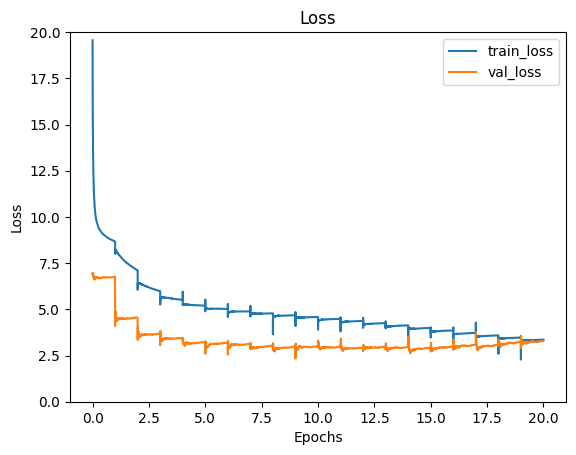

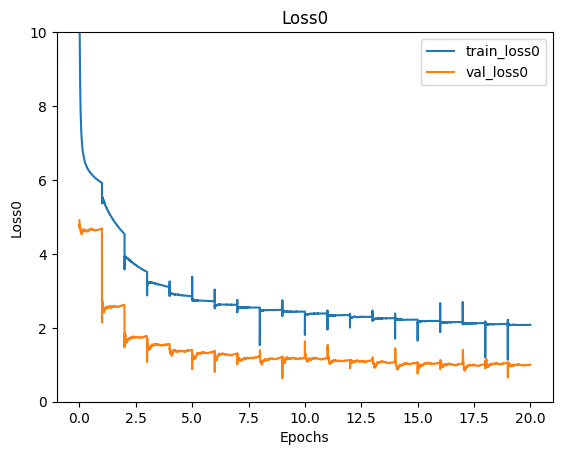

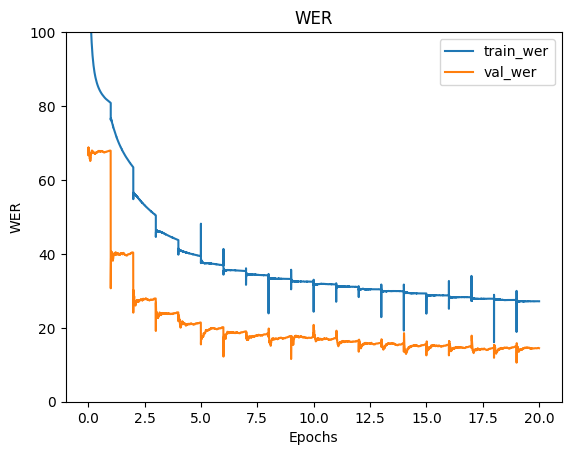

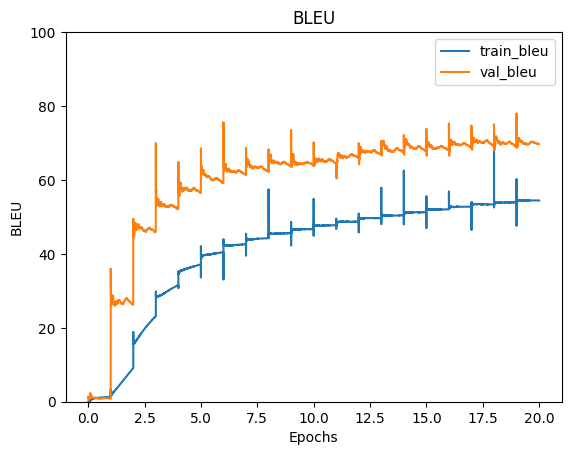

In [107]:
x = []
#print( len( history["train_loss"] ))
for i in range( len( history["train_loss"] )):
    x.append( i / 50000 )
    
v_x = []
#print( len( history["val_loss"]) )
for i in range( len( history["val_loss"]) ):
    v_x.append( i / 250 )

plt.title( "Loss")
plt.xlabel( "Epochs")
plt.ylabel( "Loss")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot( v_x, history["val_loss"], label="val_loss")
plt.ylim( 0, 20 )
plt.legend()
plt.show()

plt.title( "Loss0")
plt.xlabel( "Epochs")
plt.ylabel( "Loss0")
plt.plot(x, history["train_loss0"], label="train_loss0")
plt.plot( v_x, history["val_loss0"], label="val_loss0")
plt.ylim( 0, 10 )
plt.legend()
plt.show()

plt.title( "WER")
plt.xlabel( "Epochs")
plt.ylabel( "WER")
plt.plot(x, history["train_wer"], label="train_wer")
plt.plot( v_x, history["val_wer"], label="val_wer")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

plt.title( "BLEU")
plt.xlabel( "Epochs")
plt.ylabel( "BLEU")
plt.plot(x, history["train_bleu"], label="train_bleu")
plt.plot( v_x, history["val_bleu"], label="val_bleu")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

In [108]:
def duplicate_encoder_out(encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, beam_size):
    #print( "beam_size:", beam_size)
    encoder_out = encoder_out.unsqueeze(1).repeat(1, beam_size, 1, 1 ).view( bsz * beam_size, encoder_out.size(1), encoder_out.size(2))
    #print( "0 size of encoder_out:", encoder_out.size())
    if encoder_padding_mask is not None:
        encoder_padding_mask = encoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if decoder_padding_mask is not None:
        decoder_padding_mask = decoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if causal_mask is not None:
        #causal_mask = causal_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
        causal_mask = causal_mask

    return encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask    
        
def predict_length_beam(gold_target_len, predicted_lengths, length_beam_size):
    if gold_target_len is not None:
        beam_starts = gold_target_len - (length_beam_size - 1) // 2
        beam_ends = gold_target_len + length_beam_size // 2 + 1
        beam = torch.stack([torch.arange(beam_starts[batch], beam_ends[batch], device=beam_starts.device) for batch in range(gold_target_len.size(0))], dim=0)
    else:
        beam = predicted_lengths.topk(length_beam_size, dim=1)[1]
    beam[beam < 2] = 2
    return beam

def outputs_to_tgt_tokens( outputs, max_length0, device ):
    '''
    tgt_tokens0 = []
    token_probs0 = []
    #n = 0;
    #print( "size of outpus:", outputs.size() )
    #print( "argmax of outputs[0]:", torch.argmax( outputs[0], dim = 1 ))
    for output in outputs:
        #print( "1", model.ctc_simple_inference_cap( output ))
        tgt_tokens0.append( model.ctc_simple_inference_cap( output ) ) # n * lengths
        #print("n:" , n,  " len of tgt_tokens0:", len(tgt_tokens0[0] ))
        #n += 1
        token_probs0.append( model.ctc_simple_inference_prob( output ) )  # n * lengths

    #n = 0
    #print( "0 n:", n, "len of tgt_tokens0[n]", len( tgt_tokens0[n]))                
                
    tgt_tokens_np = np.ones( ( outputs.size(0), max_length0 )) * idx_list_en['<pad>']
    token_probs_np = np.ones( ( outputs.size(0), max_length0 ))
            
    #print( "shpae of tgt_tokens_np:", tgt_tokens_np.shape)
            
    for n in range( outputs.size(0) ):
        #print( "n:", n, "len of tgt_tokens0[n]", len( tgt_tokens0[n]))
        if len( tgt_tokens0[n] ) <= max_length0:
            tgt_tokens_np[n,:len(tgt_tokens0[n])] = tgt_tokens0[n][:]
            token_probs_np[n,:len(tgt_tokens0[n])] = token_probs0[n][:]
        else:
            tgt_tokens_np[n,:] = tgt_tokens0[n][:max_length0]
            token_probs_np[n,:] = token_probs0[n][:max_length0]
            
    tgt_tokens = torch.tensor( tgt_tokens_np, device = device )
    token_probs = torch.tensor( ( token_probs_np ), device = device  )
    '''
    outputs = F.softmax( outputs, dim = 2 )
    tgt_tokens = torch.argmax( outputs, dim = 2 )
    token_probs = torch.max( outputs, dim = 2 )[1]
    
    return tgt_tokens, token_probs

# 修正
#null_index =  j_v.get_stoi()['<pad>']
#max_length = 20

# 推論モジュール
@torch.no_grad()
def inference(
            text, is_inference = True
            ):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    #text2 = text[:,1:]
    enc_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )
    #dec_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text2, idx_list['<pad>']), dim = 1), dim = 2 ).to( torch.float64 )
    enc_outs, lengths = model.encoder( text, None, enc_padding_mask )

    length_beam_size = 3
    beam = predict_length_beam( None, lengths, length_beam_size)
    #print( "beam:",beam)
    max_len = beam.max().item()
    max_length0 = max_len
    bsz = enc_outs.size(0)
    src_tokens = text
    
    length_mask = torch.triu( src_tokens.new( max_len,max_len).fill_(1).long(),1 )
    length_mask = torch.stack([length_mask[beam[batch] - 1 ] for batch in range(bsz)], dim = 0)
    tgt_tokens = src_tokens.new( bsz, length_beam_size, max_len ).fill_(4)
    tgt_tokens = ( 1 - length_mask ) * tgt_tokens + length_mask * 5
    tgt_tokens = tgt_tokens.view( bsz * length_beam_size, max_len )
    
    def select_worst(token_probs, num_mask):
        bsz, seq_len = token_probs.size()
        masks = [token_probs[batch, :].topk(max(1, num_mask[batch]), largest=False, sorted=False)[1] for batch in range(bsz)]
        masks = [torch.cat([mask, mask.new(seq_len - mask.size(0)).fill_(mask[0])], dim=0) for mask in masks]
        return torch.stack(masks, dim=0)             

    def assign_single_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y
        return x

    def assign_single_value_byte(x, i, y):
        x.view(-1)[i.view(-1).nonzero()] = y
        return x
    
    def assign_multi_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y.view(-1)[i.view(-1)]
        return x
    
    encoder_out = enc_outs
    encoder_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )         
    text2 = text[:,1:]
    decoder_padding_mask = torch.eq(text2, idx_list['<pad>']).to( torch.float64 )         
    decoder_target_padding_mask = torch.eq(tgt_tokens, idx_list_en['<pad>']).to(torch.float64)
    #causal_mask = decoder_target_padding_mask
    #causal_mask = nn.Transformer.generate_square_subsequent_mask( tgt_tokens.shape[1] ).to(device)
    causal_mask = torch.zeros( ( tgt_tokens.shape[1], tgt_tokens.shape[1] ) ).bool()
    
    encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask = duplicate_encoder_out( encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, length_beam_size)        
    #enc_padding_mask = encoder_padding_mask, dim = 1), dim = 2 )
    #dec_padding_mask = torch.unsqueeze( torch.unsqueeze( decoder_padding_mask, dim = 1), dim = 2 )
    #causal_mask = torch.unsqueeze( torch.unsqueeze( causal_mask, dim = 1), dim = 2 )
                                               
        
    pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
    
    bsz, seq_len = tgt_tokens.size()
    pad_mask = tgt_tokens.eq(idx_list['<pad>'])
    seq_lens = seq_len - pad_mask.sum(dim=1)
    
    iter_max = 10

    #print( "size of encoder_out:", encoder_out.size())
    #print( "size of tgt_tokens:", tgt_tokens.size())
    #print( "size of causal_mask:", causal_mask.size())
    #print( "size of dec_padding_mask:", dec_padding_mask.size())
    
    
    dec_out = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool() )
    outputs = torch.nn.functional.softmax( dec_out, dim = 2 )

    tgt_tokens, token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )
    
    
    tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list_en['<pad>'] )
    token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0)
    
    for counter in range( 1, iter_max ):
        num_mask = ( seq_lens.float() * ( 1.0 - ( counter / iter_max))).long()
        #print( "num_mask:", num_mask)
        #num_mask = num_mask.unsqueeze(1).repeat(1, length_beam_size ).view( -1 )

        assign_single_value_byte(token_probs, pad_mask, 1.0)
        mask_ind = select_worst(token_probs, num_mask)

        #print("size of tgt_tokens:", tgt_tokens.size())
        #print("size of token_progs:", token_probs.size())
        #print("size of mask_ind:", mask_ind.size())
        
        tgt_tokens = assign_single_value_long(tgt_tokens, mask_ind, idx_list_en['<mask>'])
        tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list_en['<pad>'])    
        #token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0 )

        #dec_out = model.decoder(encoder_out, tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask )
        dec_out = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool() )
        outputs = torch.nn.functional.softmax( dec_out, dim = 2 )

        new_tgt_tokens, new_token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )

        token_probs = assign_multi_value_long(token_probs, mask_ind, new_token_probs)
        token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0)
            
        tgt_tokens = assign_multi_value_long(tgt_tokens, mask_ind, new_tgt_tokens)
        tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list['<pad>'])
        #print( tgt_tokens.long() )
        
    lprobs = token_probs.log().sum(-1)

    #return dec_out, lprobs
    return tgt_tokens, lprobs, max_len, length_mask

In [109]:
test_text = "それは昭和初期の映画だと思います"
#日本語用のトークン変換関数を作成
j_t = Tokenizer()
def j_tokenizer(text): 
    return [tok for tok in j_t.tokenize(text, wakati=True)]

#test_text = "わたしは生きている"

test_text = j_tokenizer( test_text )

test_ids = [ idx_list[s] for s in test_text ]
test_ids.insert( 0, idx_list['<bos>'] )
test_ids.insert( 0, idx_list['<len>'] )
test_ids.append( idx_list['<eos>'])

test_ids = torch.tensor( test_ids ).to( device )

sentence = [ token_list[str(i.item())] for i in test_ids ]

print( "sentence:", " ".join( sentence ))

test_ids = test_ids.unsqueeze( 0 )

print( "test_ids:",test_ids )
preds, lprobs, max_len, length_mask = inference( test_ids )
#preds = model.inference( test_ids )

#preds = torch.argmax( preds, dim = 2 )

#print( "preds:", preds )

#pred = preds.squeeze( 0 )

#print( "size of pred:", pred.size() )

hypotheses = preds 

bsz = test_ids.size(0)
length_beam_size = 3

#hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
#lprobs = lprobs.view(bsz, length_beam_size)
#tgt_lengths = (1 - length_mask).sum(-1)
#avg_log_prob = lprobs / tgt_lengths.float()
#best_lengths = avg_log_prob.max(-1)[1]
#hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)

#print( hypotheses )

for hypo in hypotheses:
    hyp = []
    for n in hypo:
        n = int( n.item() )
        hyp.append( token_list_en[str(n)] )
        if token_list_en[str(n)] == '<eos>' or token_list_en[str(n)] == '<pad>':
            break
    print( ' '.join( hyp ))
        

#sent= ctc_simple_decode( pred[0], token_list_en)

#print( 'probs[0]',lprobs[0],' '.join(sent) )

#sent= ctc_simple_decode( pred[1], token_list_en)

#print( 'probs[1]',lprobs[1],' '.join(sent) )

#sent= ctc_simple_decode( pred[2], token_list_en)

#print( 'probs[2]',lprobs[2],' '.join(sent) )

sentence: <len> <bos> それ は 昭和 初期 の 映画 だ と 思い ます <eos>
test_ids: tensor([[   6,    1,  752,   12, 4068, 2651,   10, 4235,  231,   18,  137,   49,
            2]])
<bos> i think i think this film is an early movie . <eos>
<bos> i think that showa is an early movie . <eos>
<bos> i think that showa showa is an early movie . <eos>


In [110]:
'''
test_text = "現在、筋ジストロフィー患者の移動介助において文書マニュアルを使用している。"
#test_text = "わたしは生きている"

test_text = j_tokenizer( test_text )

test_ids = [ idx_list[s] for s in test_text ]
test_ids.insert( 0, idx_list['<bos>'] )
test_ids.append( idx_list['<eos>'])
'''
test_ids = [6, 1, 6222, 67, 111, 8578, 12, 998, 631, 12752, 32, 5943, 136, 303, 45, 227, 49, 22, 2]

test_ids = torch.tensor( test_ids ).to( device )

sentence = [ token_list[str(i.item())] for i in test_ids ]

print( "sentence:", " ".join( sentence ))

# 正解の文字列を取得
caption = [1, 47, 4492, 6975, 1005, 35, 1516, 156, 15991, 11579, 16, 2]
reference = []
for m in caption:
    reference.append( token_list_en[str(m)])
    if m == idx_list_en['<eos>']:
        break    

print( "reference :", " ".join(reference))        

refs = [ reference ]

test_ids = test_ids.unsqueeze( 0 )

#print( "test_ids:",test_ids )

#preds = inference( test_ids )
#preds = beam_search( test_ids )
preds, lprobs, max_len, length_mask = inference( test_ids )
#print( "size of preds:", preds.size() )
#print( "preds:", preds )

hypotheses = preds 

bsz = test_ids.size(0)
length_beam_size = 3

hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
lprobs = lprobs.view(bsz, length_beam_size)
tgt_lengths = (1 - length_mask).sum(-1)
avg_log_prob = lprobs / tgt_lengths.float()
best_lengths = avg_log_prob.max(-1)[1]
hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)

#print( "size of hypotheses:", hypotheses.size())
pred = torch.squeeze( hypotheses, dim = 0 )

#print( pred )

sent = []
for m in pred:
    #print( m )
    sent.append( token_list_en[str(m.item())])
    if token_list_en[str(m.item())] == '<eos>':
        break
    
print( 'hypotheses:', ' '.join(sent) )

# 認識誤りを計算
(error, substitute, 
    delete, insert, ref_length) = \
    levenshtein.calculate_error(reference, sent)

#bleu = bleu_score.sentence_bleu( refs, sent, smoothing_function=fn)
#print( refs )
#print( hypotheses )
bleu = bleu_score.sentence_bleu( refs, sent)
#bleu = bleu_score1( refs, sent )
#print( bleu )
#bleu = bleu_score.sentence_bleu( reference, sent)


print( "WER:", error / len( sent )  * 100, "BLEU:", bleu * 100 )

sentence: <len> <bos> 完成 し た 石鹸 は 通気 性 包装 に 保管 する 必要 が あり ます 。 <eos>
reference : <bos> the finished soap must be stored in breathable packaging . <eos>
hypotheses: <bos> finished soap must be stored in breathable packaging . <eos>
WER: 9.090909090909092 BLEU: 83.52052074548169


In [21]:
test_dataset = SequenceDataset( "20240512_ntt_ids_test_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )

test_loader = DataLoader(test_dataset,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0)

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3490
n: 3491
n: 3492
n: 3493
n: 3494
n: 3495
n: 3496
n: 3497
n: 3498
n: 3499
n: 3500
n: 3501
n: 3502
n: 3503
n: 3504
n: 3505
n: 3506
n: 3507
n: 3508
n: 3509
n: 3510
n: 3511
n: 3512
n: 3513
n: 3514
n: 3515
n: 3516
n: 3517
n: 3518
n: 3519
n: 3520
n: 3521
n: 3522
n: 3523
n: 3524
n: 3525
n: 3526
n: 3527
n: 3528
n: 3529
n: 3530
n: 3531
n: 3532
n: 3533
n: 3534
n: 3535
n: 3536
n: 3537
n: 3538
n: 3539
n: 3540
n: 3541
n: 3542
n: 3543
n: 3544
n: 3545
n: 3546
n: 3547
n: 3548
n: 3549
n: 3550
n: 3551
n: 3552
n: 3553
n: 3554
n: 3555
n: 3556
n: 3557
n: 3558
n: 3559
n: 3560
n: 3561
n: 3562
n: 3563
n: 3564
n: 3565
n: 3566
n: 3567
n: 3568
n: 3569
n: 3570
n: 3571
n: 3572
n: 3573
n: 3574
n: 3575
n: 3576
n: 3577
n: 3578
n: 3579
n: 3580
n: 3581
n: 3582
n: 3583
n: 3584
n: 3585
n: 3586
n: 3587
n: 3588
n: 3589
n: 3590
n: 3591
n: 3592
n: 3593
n: 3594
n: 3595
n: 3596
n: 3597
n: 3598
n: 3599
n: 3600
n: 3601
n: 3602
n: 3603
n: 3604
n: 3605
n: 3606
n: 3607
n: 3608
n: 3609
n: 3610
n: 3611
n: 3612
n: 3613
n: 3614


In [111]:
model.eval()
print("Test")

n = 0
total_error0 = 0
total_token_length0 = 0
total_bleu0 = 0
for i, (text, label, text_len, target_len) in enumerate(test_loader):
    if i > 50:
        break
    text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
    #print( "val i:", i )

    with torch.no_grad():
        preds, lprobs, max_len, length_mask = inference( text )
        hypotheses = preds
        
        #print( "size of hypotheses:", hypotheses.size())

        bsz = text.size(0)
        length_beam_size = 3

        hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
        lprobs = lprobs.view(bsz, length_beam_size)
        tgt_lengths = (1 - length_mask).sum(-1)
        avg_log_prob = lprobs / tgt_lengths.float()
        best_lengths = avg_log_prob.max(-1)[1]
        hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)        
    
    n2 = 0
    jap_sentence = []
    hypo_sentence = []
    ref_sentence = []
    total_error = 0
    total_token_length = 0
    test_loss = 0
    total_bleu = 0
    for hypo_id, caption, japa in zip( hypotheses, label, text ):
        jap = []
        for m in japa:
            jap.append( token_list[str(m.item())])
            if m == idx_list['<eos>']:
                break
        hypo = []
        for m in hypo_id:
            hypo.append(token_list_en[str(int(m.item()))])
            if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
                break
        #hypo = ctc_simple_decode( hypo_id, token_list_en)
        # 正解の文字列を取得
        reference = []
        for m in caption:
            reference.append( token_list_en[str(m.item())])
            if m == idx_list_en['<eos>']:
                break
                        
        # 認識誤りを計算
        (error, substitute, 
            delete, insert, ref_length) = \
            levenshtein.calculate_error(hypo,reference)

        bleu = bleu_score.sentence_bleu( [reference], hypo)
        
        total_bleu += bleu
        total_bleu0 += bleu
        total_error += error
        total_error0 += error
        total_token_length += ref_length
        total_token_length0 += ref_length

        #if n2 < 4 and i == len( val_loader ) -1 :
        jap_sentence.append( ''.join(jap))
        hypo_sentence.append( ' '.join(hypo) )
        ref_sentence.append( ' '.join(reference ) )
                    
        n2 += 1
        n += 1
        
    #a = nltk.translate.bleu_score.corpus_bleu(reference, hypothesis, smoothing_function=fn)
        
    print(f"index:{i+1}  WER: {total_error / total_token_length * 100:.10f}")
    print(f"index:{i+1}  BLEU:{total_bleu / n2 * 100: 10f}")
    #if i == len( test_loader ) - 1:
    for i, (hypo_s, refe_s, jap_s ) in enumerate( zip( hypo_sentence, ref_sentence, jap_sentence ) ):
        if i > 4:
            break
        print( "japa:", jap_s)
        print( "refe:", refe_s)
        print( "hypo:", hypo_s )
        
print(f"index:{i+1}  WER0: {total_error0 / total_token_length0 * 100:.10f}")
print(f"index:{i+1}  BLEU0:{total_bleu0 / n * 100: 10f}")


Test
index:1  WER: 8.3333333333
index:1  BLEU: 83.520521
japa: <len><bos>完成した石鹸は通気性包装に保管する必要があります。<eos>
refe: <bos> the finished soap must be stored in breathable packaging . <eos>
hypo: <bos> finished soap must be stored in breathable packaging . <eos>
index:2  WER: 21.4285714286
index:2  BLEU: 53.036246
japa: <len><bos>そのような困難な仕事を占めた最初の会社はバッファローでした。<eos>
refe: <bos> the first company that occupied such a difficult task was buffalo . <eos>
hypo: <bos> the first company who occupied such a difficult task was buffer low . <eos>
index:3  WER: 8.3333333333
index:3  BLEU: 73.488892
japa: <len><bos>最初の評議会は6月末にハッチングします。<eos>
refe: <bos> the first council hatches at the end of june . <eos>
hypo: <bos> the first council hatching at the end of june . <eos>
index:4  WER: 9.0909090909
index:4  BLEU: 81.649658
japa: <len><bos>最初に炭水化物、タンパク質、脂肪を含む。<eos>
refe: <bos> the first includes carbohydrates , proteins , fats . <eos>
hypo: <bos> the first includes carbohydrates carbohydrates , proteins , fats 

index:30  WER: 28.5714285714
index:30  BLEU: 37.868118
japa: <len><bos>財団は具体的なスクリードを建設するのが簡単で安くなります。<eos>
refe: <bos> the foundation is easier and cheaper to build a concrete screed . <eos>
hypo: <bos> foundation foundation becomes easy and cheaper to build concrete screed . <eos>
index:31  WER: 35.7142857143
index:31  BLEU:  0.000000
japa: <len><bos>ネジ山の基礎は最も合理的なデザインです。<eos>
refe: <bos> the foundation on the screw piles is the most rational design . <eos>
hypo: <bos> the basis of screw pile is the most reasonable design . <eos>
index:32  WER: 26.6666666667
index:32  BLEU: 63.258467
japa: <len><bos>フレームが内側にノックアウトされており、釘は外側に曲がっています。<eos>
refe: <bos> the frame is knocked out inside , and nails are bent outside . <eos>
hypo: <bos> the frame that the frame is knocked out inside , the nails are bent outside . <eos>
index:33  WER: 20.0000000000
index:33  BLEU: 49.658283
japa: <len><bos>フレームワークはボードや木の杭の冬に設置されています。<eos>
refe: <bos> the framework is installed for the winter of boards or wooden 